
!!! questions "Questions"  
    - How do we implement tree-based and proximity-based 
      methods in python?
      
!!! objectives "Objectives"  
    - To fit a RF and KNN model to our data
    - To explore the effect of hyperparameters on model fit



## Random forest regression. K nearest neighbor regression

In [1]:
import os
current_work_dir = %pwd
MLPY_ROOT = current_work_dir.split('course')[0]
NOTEBOOK_FOLDER = os.path.join(MLPY_ROOT, 'course',  'notebooks')
MODELS_FOLDER = os.path.join(NOTEBOOK_FOLDER, 'models')

import warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=DeprecationWarning)

# when delivering live coding, these libraries and code in this cell have already been loaded
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import exp10
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer

from sklearn.utils import resample


# Set up plotting options for seaborn and matplotlib
sns.set_context('notebook') 
sns.set_style('ticks') 
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# load from previous lessons
cached_files = [
    'ames_train_y.pickle', 'ames_test_y.pickle',
    'ames_train_X.pickle', 'ames_test_X.pickle',
    'predictors.pickle', 'ames_ols_all.pickle',
    'ames_ridge.pickle', 'ames_lasso.pickle', 
    'ames_enet.pickle', 
    'ames_pcr.pickle', 'ames_plsr.pickle'
]

for file in cached_files:
    with open(os.path.join(MODELS_FOLDER, file), 'rb') as f:
        objectname = file.replace('.pickle', '')
        exec(objectname + " = pickle.load(f)")
        f.close()

# transformation function for Y
log_transf_f = FunctionTransformer(
    func=np.log10,
    inverse_func=exp10,
    validate=True
)

# function to create scores dataframe
def assess_model_fit(models, model_labels, datasetX, datasetY):
    columns = ['RMSE', 'R2', 'MAE']
    results = pd.DataFrame(0.0, columns=columns, index=model_labels)
    y_actual = log_transf_f.inverse_transform(datasetY.reshape(-1, 1))
    for i, method in enumerate(models):
        tmp_dataset_X = datasetX
        # while we build the model and predict on the log10Transformed 
        # sale price, we display the error in dollars as that makes more sense
        y_pred = log_transf_f.inverse_transform(method.predict(datasetX).reshape(-1, 1))
        results.iloc[i,0] = np.sqrt(mean_squared_error(y_actual, y_pred))
        results.iloc[i,1] = r2_score(y_actual, y_pred)
        results.iloc[i,2] = mean_absolute_error(y_actual, y_pred)
    return results.round(3)

# Plot coefficients/feature importances
def plot_coefficients(model, labels):
    # Support both regression/regularised regression and 
    #   random forest models
    if hasattr(model, 'coef_'):
        coefs = model.coef_.ravel()
        title = 'Estimated coefficients'
    elif hasattr(model, 'feature_importances_'):
        coefs = model.feature_importances_
        title = 'Feature importances'
    table = pd.Series(coefs, index = labels)
    # Get the largest 20 values (by absolute value)
    table = table[table.abs().nlargest(20).index].sort_values()

    fig, ax = fig, ax = plt.subplots()
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title(title + ' (twenty largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

## Random Forest
In random forest, each tree in the ensemble is built from a bootstrap sample from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is the best split among a random subset of the features.

In [2]:
# tuning grid was defined to optimise the following RF parameters:
param_grid = {"n_estimators": list(np.arange(10,160,10)),
            'max_depth': list(np.arange(3,11,1)),
            'min_samples_split': [0.005, 0.01, 0.02],
             'max_features': ['sqrt', 'auto']}

This was optimised on the HPC (we'll see some sample scripts for this in the next session), and the best outcome of this ended up being:

```
{'max_depth': 9, 'min_samples_split': 0.005, 
'max_features': 'auto', 'n_estimators': 150}

# best score
0.8735794018428228
```


In [3]:
from sklearn.ensemble import RandomForestRegressor

ames_RF = Pipeline([
    ('estimator', RandomForestRegressor(n_estimators=150, 
                                       max_depth = 9,
                                       min_samples_split = 0.005,
                                       max_features = 'auto'))
    # If we want to actually tune these parameters
    #('estimator', GridSearchCV(RandomForestRegressor(), param_grid, scoring='r2', cv=10))
])

ames_RF.fit(ames_train_X, ames_train_y)
# Save model for later notebooks
pickle.dump(ames_RF, open(os.path.join(MODELS_FOLDER, 'ames_RF.pickle'), 'wb'))
    
#best_RF = ames_RF.named_steps.estimator.best_estimator_
#print(best_RF)

In [4]:
ames_RF.named_steps['estimator']

RandomForestRegressor(max_depth=9, max_features='auto', min_samples_split=0.005,
                      n_estimators=150)

!!! challenge "Challenge 1"
    1. Try different hyperparameters, how does it impact the feature importances and RMSE (see below)?

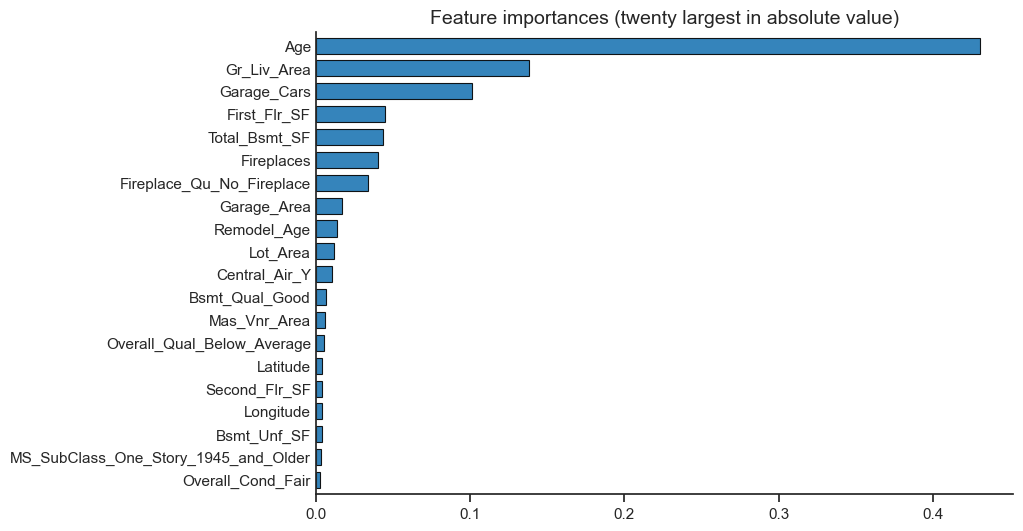

In [5]:
plot_coefficients(ames_RF.named_steps['estimator'], predictors)
plt.show()

!!! info
    The plot above shows the impurity-based feature importances, which are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

One disadvantage of impurity-based feature importances is that this can be biased towards features with many unique values (high cardinality). To overcome this bias one can perform a permutation feature importance as shown below (this might take a bit longer to run)

!!! note
    Note that feature importance based on permutations are model-agnostic and can be applied for other models as well. 

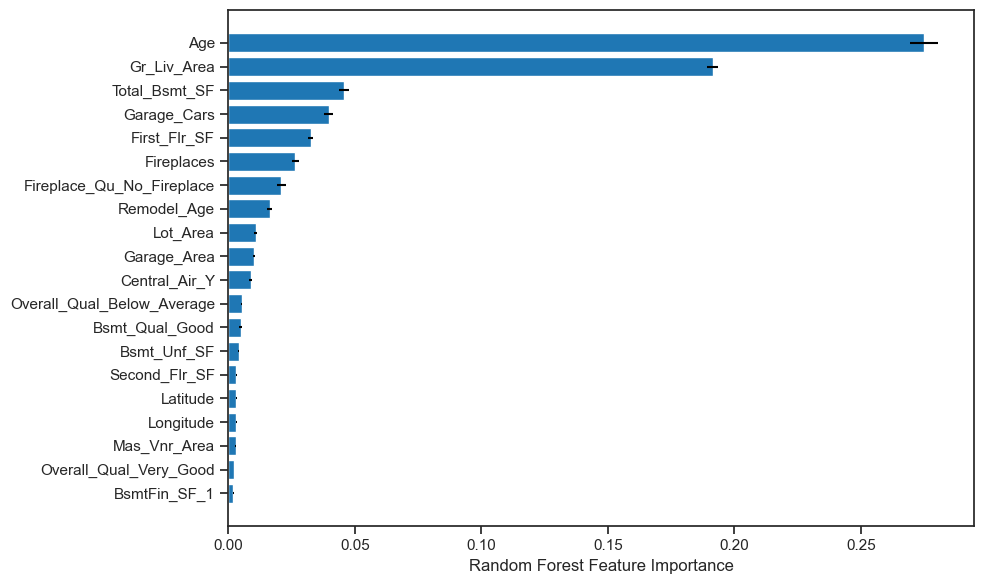

In [6]:
perm_res = permutation_importance(ames_RF, ames_train_X, ames_train_y, n_repeats=5, random_state=0, n_jobs=2)
corrcoef_rf = np.asarray(perm_res.importances_mean)
corrcoef_rf_std = np.asarray(perm_res.importances_std)
#Select 20 largest only
sorted_idx = corrcoef_rf.argsort()[-20:]
fig, ax = plt.subplots(figsize = (10,6))
bar = ax.barh(np.arange(20), corrcoef_rf[sorted_idx], xerr = corrcoef_rf_std[sorted_idx],
 tick_label = np.asarray(predictors)[sorted_idx], align='center')
plt.xlabel("Random Forest Feature Importance")
plt.tight_layout()

## k-Nearest Neighbours Regression

In [7]:
# tuning grid will be defined to optimise the following knn parameters:
param_grid = {"n_neighbors": list(np.arange(3,21,2)),
              "weights": ['uniform','distance'],
             }

# Results from tuning:
# print(ames_kNN.named_steps['estimator'].best_score_)
# 0.7842456772785913
# KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',metric_params=None, n_jobs=1, n_neighbors=7, p=2, weights='distance')

In [8]:
from sklearn.neighbors import KNeighborsRegressor

# Next, let's try to tune locally, trying 6, 7 and 8 neighbors:
param_grid = {"n_neighbors": [6,7,8],
              "weights": ['uniform']}


ames_kNN = Pipeline([
    ('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('estimator', KNeighborsRegressor(n_neighbors=10))
    ('estimator', GridSearchCV(KNeighborsRegressor(), 
                               param_grid, scoring='r2', cv=10))
])

ames_kNN.fit(ames_train_X, ames_train_y)
# Save model for later notebooks
pickle.dump(ames_kNN, open(os.path.join(MODELS_FOLDER, 'ames_knn.pickle'), 'wb'))
    
print(ames_kNN.named_steps['estimator'].best_estimator_)
print(ames_kNN.named_steps['estimator'].best_score_)

KNeighborsRegressor(n_neighbors=7)
0.778996444922293


## Compare Models

In [9]:
# What was the RMSE on the training data?
compare_train = assess_model_fit(
    models=[ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_pcr,
            ames_plsr, ames_RF, ames_kNN],
    model_labels=['OLS','Ridge', 'Lasso', 'ENet','PCR','PLSR', 'RF', 'kNN'],
    datasetX=ames_train_X,
    datasetY=ames_train_y)
compare_train.sort_values('RMSE')

,RMSE,R2,MAE
OLS,15751.090,0.961,10933.508
RF,16129.498,0.959,10966.223
Lasso,16480.809,0.957,11448.829
Ridge,16493.543,0.957,11463.828
PLSR,16518.167,0.957,11608.870
PCR,16775.707,0.955,11796.080
ENet,17041.263,0.954,11799.805
kNN,31067.840,0.847,19718.647


In [10]:
def rearrange_df(df):
    out_df = (
        df.copy()
        .reset_index()
        .melt(
            id_vars='index',
            value_vars=df.columns.values.tolist(),
            var_name='metric',
            value_name='number'
        )
        .sort_values('number')
    )
    out_df['index'] = out_df['index'].astype(str)
    out_df= out_df.rename(columns={'index':'model_features'})
    return out_df

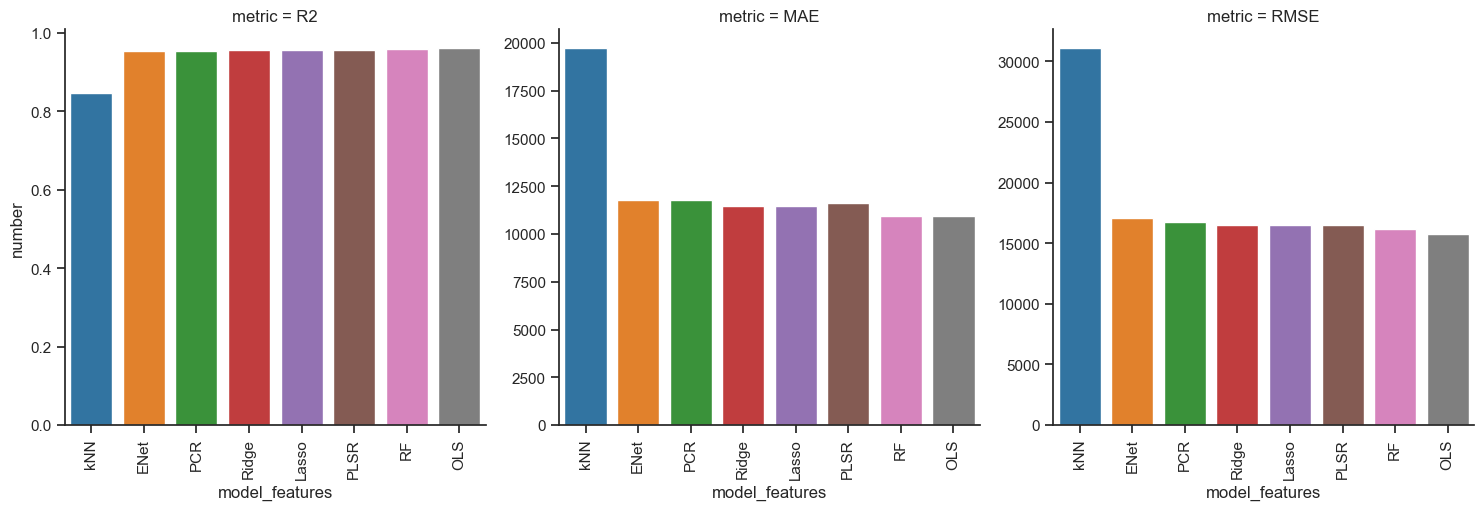

In [11]:
chart = sns.catplot(
    x='model_features',
    y='number',
    col='metric',
    data=rearrange_df(compare_train),
    kind='bar',
    sharey=False,
)
chart.set_xticklabels(rotation=90);

In [12]:
# What was the RMSE on the testing data?
compare_test = assess_model_fit(
    models=[ames_ols_all, ames_ridge, ames_lasso, ames_enet, 
            ames_pcr, ames_plsr, ames_RF, ames_kNN],
    model_labels=['OLS','Ridge', 'Lasso', 'ENet','PCR','PLSR', 'RF', 'kNN'],
    datasetX=ames_test_X,
    datasetY=ames_test_y)
compare_test.sort_values('RMSE')

,RMSE,R2,MAE
ENet,19801.137,0.933,13317.484
Lasso,19864.494,0.933,13120.146
Ridge,20055.583,0.931,13284.272
PLSR,20094.727,0.931,13376.642
OLS,20602.458,0.928,13355.654
PCR,21171.149,0.924,14026.781
RF,27014.053,0.876,16667.099
kNN,34692.512,0.795,23087.591


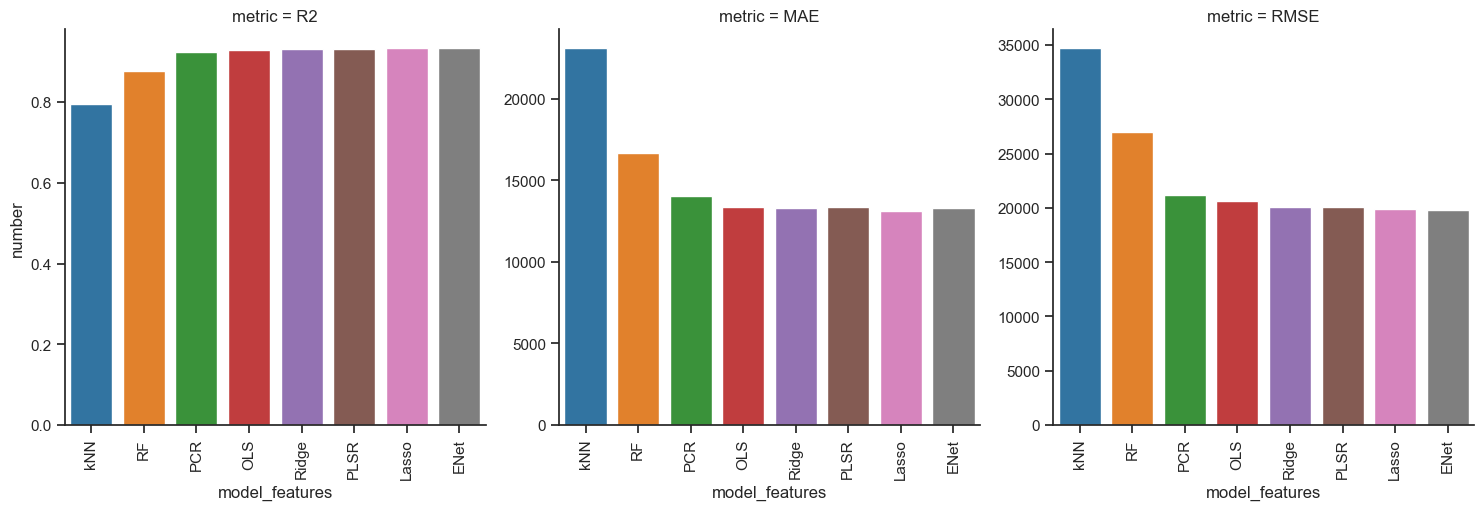

In [13]:
chart = sns.catplot(
    x='model_features',
    y='number',
    col='metric',
    data=rearrange_df(compare_test),
    kind='bar',
    sharey=False,
)
chart.set_xticklabels(rotation=90);

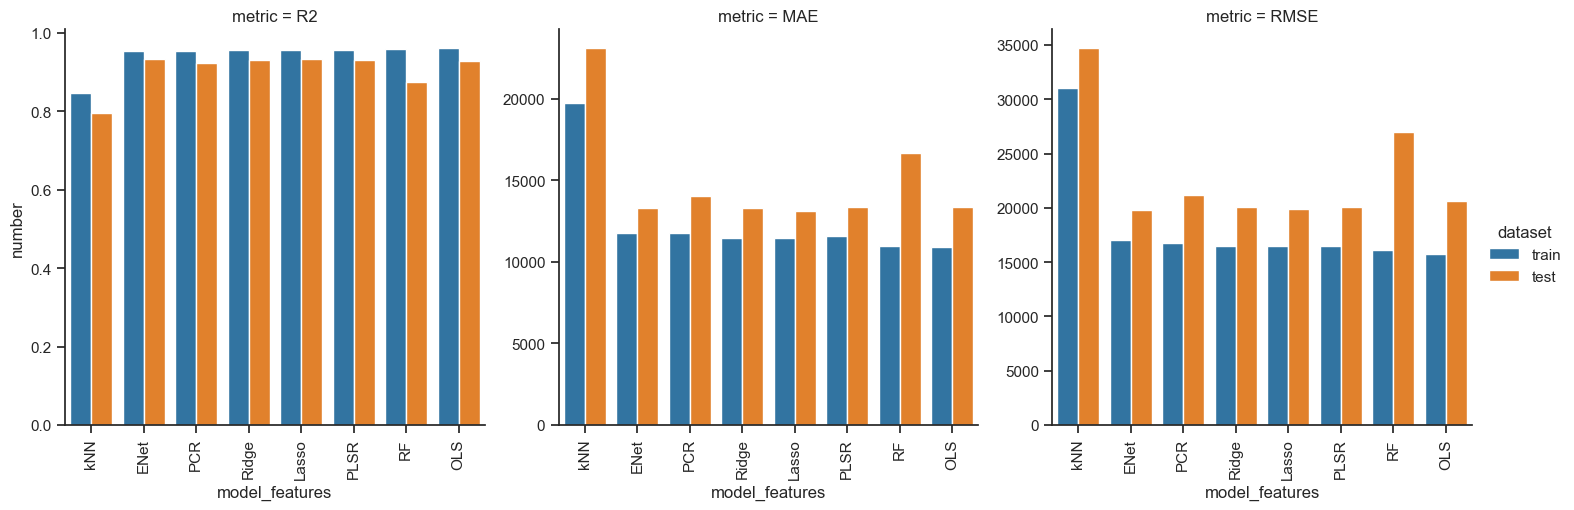

In [14]:
# compare train vs test scores
def combine_train_test_res_df(df_train_scores, df_test_scores):
    df = rearrange_df(df_train_scores)
    df['dataset'] = 'train'
    df1 = rearrange_df(df_test_scores)
    df1['dataset'] = 'test'
    return pd.concat([df, df1])

chart = sns.catplot(
    x='model_features',
    y='number',
    col='metric',
    data=combine_train_test_res_df(compare_train, compare_test),
    kind='bar',
    sharey=False,
    hue='dataset'
)
chart.set_xticklabels(rotation=90);

!!! keypoints "Key points"  
    - Random forests can be combined to solve regression tasks
    - kNN is a method that can also be used for regression